# BWT - Deep Learning Tack
## Task#29: Topics: Using a Pre-Trained ConvNet Architecture Performing Feature Extraction and Fine Tuning
### Adil Mubashir Chaudhry




#### Using a pretrained convnet
A common and highly effective apprach to apply deep learning on small image datasets is to use a pretrained network. Pretrained networks are trained on large scale datasets and already have features tuned into them. These are especially useul in computer vision problems. 

There are 2 ways to use pretrained network: feature extraction and fine-tuning.


#### Feature extraction

This consists of using represenations learned by previous network to extract interesting features in new samples

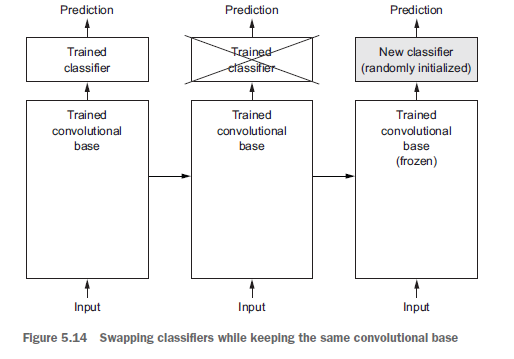



In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/adilm/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,target_size=(150, 150), batch_size=batch_size,
                                             class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 553ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 557ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 561ms/step


In [4]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),

loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                     validation_data=(validation_features, validation_labels))

Epoch 1/30


C:\Users\adilm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 2s 18ms/step - loss: 0.6301 - acc: 0.6480 - val_loss: 0.4563 - val_acc: 0.8190
Epoch 2/30
100/100 [==============================] - 2s 17ms/step - loss: 0.4306 - acc: 0.7985 - val_loss: 0.3606 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3665 - acc: 0.8440 - val_loss: 0.3224 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3138 - acc: 0.8750 - val_loss: 0.2987 - val_acc: 0.8890
Epoch 5/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2857 - acc: 0.8825 - val_loss: 0.2876 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2603 - acc: 0.8960 - val_loss: 0.2730 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2494 - acc: 0.9050 - val_loss: 0.2669 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 2s 17ms/step - loss: 0.234

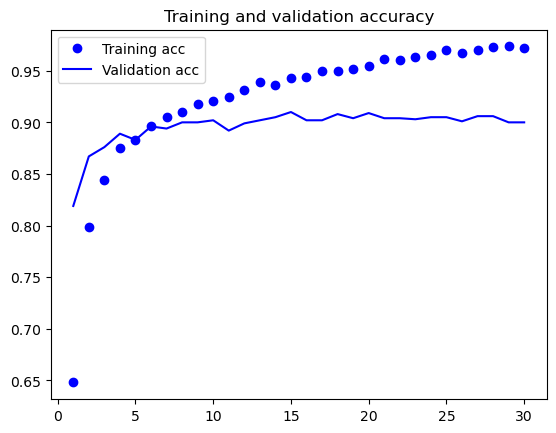

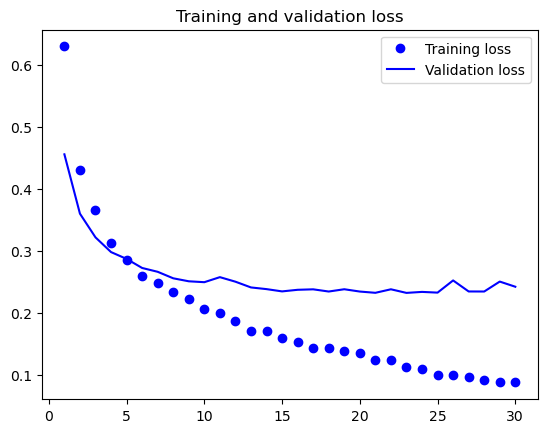

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10


C:\Users\adilm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\adilm\AppData\Local\Temp\ipykernel_6048\3499082276.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


50/50 [==============================] - 58s 1s/step - loss: 0.6422 - acc: 0.6470 - val_loss: 0.5405 - val_acc: 0.7510
Epoch 2/10
50/50 [==============================] - 59s 1s/step - loss: 0.5635 - acc: 0.7250 - val_loss: 0.4456 - val_acc: 0.8320
Epoch 3/10
50/50 [==============================] - 59s 1s/step - loss: 0.4888 - acc: 0.7910 - val_loss: 0.4042 - val_acc: 0.8260
Epoch 4/10
50/50 [==============================] - 64s 1s/step - loss: 0.4568 - acc: 0.8030 - val_loss: 0.3708 - val_acc: 0.8420
Epoch 5/10
50/50 [==============================] - 64s 1s/step - loss: 0.4450 - acc: 0.8100 - val_loss: 0.3416 - val_acc: 0.8610
Epoch 6/10
50/50 [==============================] - 61s 1s/step - loss: 0.4390 - acc: 0.8120 - val_loss: 0.3295 - val_acc: 0.8640
Epoch 7/10
50/50 [==============================] - 62s 1s/step - loss: 0.4014 - acc: 0.8310 - val_loss: 0.3143 - val_acc: 0.8710
Epoch 8/10
50/50 [==============================] - 62s 1s/step - loss: 0.4280 - acc: 0.8050 - val_lo

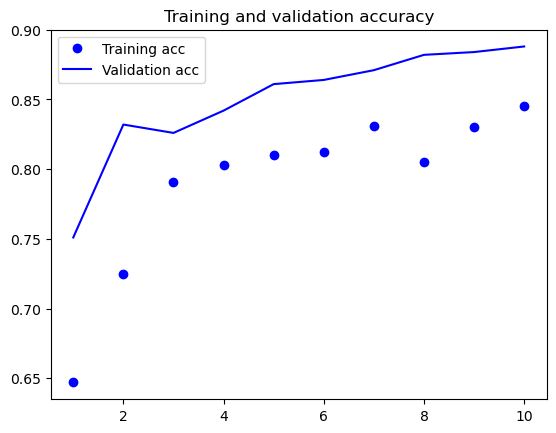

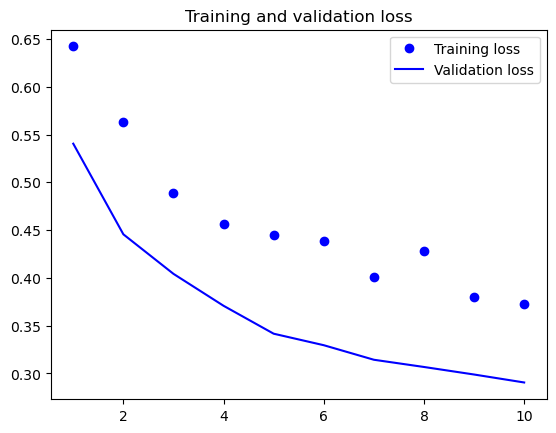

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=6,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/6


C:\Users\adilm\AppData\Local\Temp\ipykernel_6048\2217087409.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


30/30 [==============================] - 59s 2s/step - loss: 0.3668 - acc: 0.8317 - val_loss: 0.2638 - val_acc: 0.8910
Epoch 2/6
30/30 [==============================] - 55s 2s/step - loss: 0.3548 - acc: 0.8383 - val_loss: 0.2465 - val_acc: 0.8950
Epoch 3/6
30/30 [==============================] - 56s 2s/step - loss: 0.2948 - acc: 0.8833 - val_loss: 0.2553 - val_acc: 0.8870
Epoch 4/6
30/30 [==============================] - 59s 2s/step - loss: 0.3120 - acc: 0.8617 - val_loss: 0.2372 - val_acc: 0.9000
Epoch 5/6
30/30 [==============================] - 61s 2s/step - loss: 0.3001 - acc: 0.8600 - val_loss: 0.2205 - val_acc: 0.9090
Epoch 6/6
30/30 [==============================] - 65s 2s/step - loss: 0.2616 - acc: 0.8867 - val_loss: 0.2086 - val_acc: 0.9100


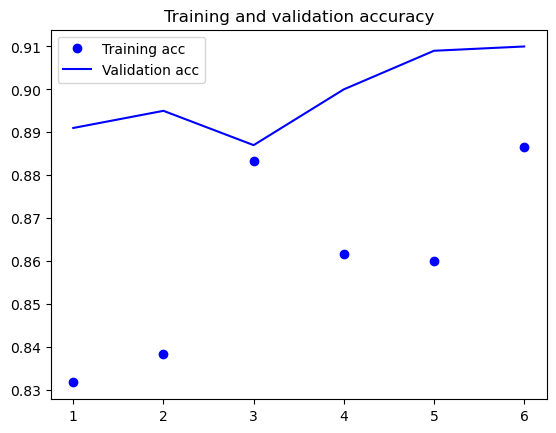

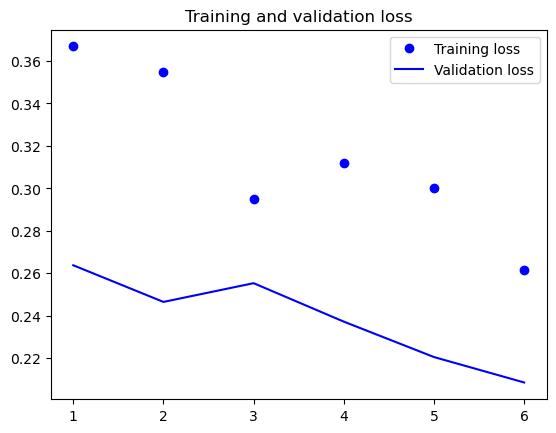

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\adilm\AppData\Local\Temp\ipykernel_6048\2940250241.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9070000052452087
